# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The goal of this project is to determine the features of a used car (independent variables) that has the most impact on it's resale price.

This can be achieved by computing the importance mean of the top features. The importance mean in turn can be computed after determining the optimal model that would predict the price based on the available real world data.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [450]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector, RFE

import numpy as np
import matplotlib.pyplot as plt

In [451]:
cars = pd.read_csv('data/vehicles.csv')

In [452]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

By looking at the features, the following features seem most relevant to the price, as a starting point for data analysis:

region
year
manufacturer
model
condition
cylinders
odometer
transmission
size
type

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

# We will first analyze the data to decide on the preparation it needs

In [453]:
def inspect_cols (df, select_col):
    for cols in select_col:
        print ('\n\n')
        print (cols)
        print ("--------------")
        if (df.dtypes[cols] == 'object'):
            print (df[cols].value_counts())
        missing = df[cols].isnull().sum()
        perct = missing / len(df[cols]) * 100
        print (f'Null (%): ', missing, round(perct, 2))

In [454]:
# Analyze non numeric features

inspect_cols(cars, 
 ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'transmission', 'size', 'type', 'year', 'odometer'])




region
--------------
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: region, Length: 404, dtype: int64
Null (%):  0 0.0



manufacturer
--------------
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick               5501
mazda     

# Based on the results above we prepare data as follows

1. Deal with null/NaN values which appears to be a significant issue with this dataset
    1. Size: Drop this feature which has 72% of the values missing
    1. Cylinders: Drop this feature as it has almost half of the values missing
    1. Condition: Since this is a relatively important feature let's replace null with a new category 'unknown'
    1. Manufacturer: With just 4% of values null, we will put down the manufacturer as 'unknown'
    1. Model: We will add the 1% of missing values to the existing 'other' model
    1. transmission: We will add missing values to the existing 'other' transmission 
    1. type: Missing values will be set to the existing 'other' type
    1. year, odometer: Since both of these are important for used cars and have small number of null, we'll drop rows that have null for these features
1. Encode non numeric data into numbers
    1. transmisison: For this feature for which we will use one hot encoder
    1. All other features: We will use label encoder to convert values to numeric

In [455]:
# Perform the null replacements

cars['condition'].fillna("unknown", inplace=True)
cars['manufacturer'].fillna("unknown", inplace=True)
cars['model'].fillna("other", inplace=True)
cars['transmission'].fillna("other", inplace=True)
cars['type'].fillna("other", inplace=True)

encode_cols = ['region', 'manufacturer', 'model', 'condition', 'transmission', 'type']
inspect_cols(cars, encode_cols)




region
--------------
columbus                   3608
jacksonville               3562
spokane / coeur d'alene    2988
eugene                     2985
fresno / madera            2983
                           ... 
meridian                     28
southwest MS                 14
kansas city                  11
fort smith, AR                9
west virginia (old)           8
Name: region, Length: 404, dtype: int64
Null (%):  0 0.0



manufacturer
--------------
ford               70985
chevrolet          55064
toyota             34202
honda              21269
nissan             19067
jeep               19014
ram                18342
unknown            17646
gmc                16785
bmw                14699
dodge              13707
mercedes-benz      11817
hyundai            10338
subaru              9495
volkswagen          9345
kia                 8457
lexus               8200
audi                7573
cadillac            6953
chrysler            6031
acura               5978
buick     

In [456]:
# Now encode all non numeric to numeric values

encode_cols.remove('transmission') # we will use one hot encoder for this feature

cars[encode_cols] = cars[encode_cols].apply(LabelEncoder().fit_transform)
    
inspect_cols(cars, encode_cols)




region
--------------
Null (%):  0 0.0



manufacturer
--------------
Null (%):  0 0.0



model
--------------
Null (%):  0 0.0



condition
--------------
Null (%):  0 0.0



type
--------------
Null (%):  0 0.0


In [457]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  int64  
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  426880 non-null  int64  
 5   model         426880 non-null  int64  
 6   condition     426880 non-null  int64  
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  426880 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          426880 non-null  int64  
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [458]:
# Let us see what a correlation map says about impact of features on price

cars.corr()

/var/folders/8z/9jzpx8qj30j0gz7l941d1v_c0000gq/T/ipykernel_26446/3936115251.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cars.corr()


,id,region,price,year,manufacturer,model,condition,odometer,type
id,1.000000,0.006936,-0.002779,-0.059040,0.033209,-0.010034,-0.005921,0.010721,0.020755
region,0.006936,1.000000,-0.001412,-0.003711,0.000983,-0.000296,-0.021107,-0.001237,0.002664
price,-0.002779,-0.001412,1.000000,-0.004925,0.002104,0.000019,0.001140,0.010032,0.000799
year,-0.059040,-0.003711,-0.004925,1.000000,-0.021740,0.045864,0.089604,-0.157215,0.003033
manufacturer,0.033209,0.000983,0.002104,-0.021740,1.000000,-0.094283,-0.001014,0.011179,0.040760
model,-0.010034,-0.000296,0.000019,0.045864,-0.094283,1.000000,-0.015170,-0.006580,-0.100437
condition,-0.005921,-0.021107,0.001140,0.089604,-0.001014,-0.015170,1.000000,-0.007196,0.039499
odometer,0.010721,-0.001237,0.010032,-0.157215,0.011179,-0.006580,-0.007196,1.000000,0.011971
type,0.020755,0.002664,0.000799,0.003033,0.040760,-0.100437,0.039499,0.011971,1.000000


Interestingly there's no significant correlation seen between price and the numeric features. So, let's move on to build models to try and determine the features that impact price the most.

In [459]:
# Let's now split the data for training and testing

# add back numeric features
X = cars[encode_cols + ['transmission', 'year', 'odometer', 'price']]
X = X.dropna()

y = X['price']
del(X['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337075 entries, 112987 to 11123
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        337075 non-null  int64  
 1   manufacturer  337075 non-null  int64  
 2   model         337075 non-null  int64  
 3   condition     337075 non-null  int64  
 4   type          337075 non-null  int64  
 5   transmission  337075 non-null  object 
 6   year          337075 non-null  float64
 7   odometer      337075 non-null  float64
dtypes: float64(2), int64(5), object(1)
memory usage: 23.1+ MB


## Linear Regression with Polynomial Feature Selection

In [460]:
# Let's start with a Linear Regression model with Polynomial 

col_transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), 
                    ['transmission']), remainder='passthrough', verbose_feature_names_out=False)
pipe = Pipeline([('transformer', col_transformer),
                    ("poly", PolynomialFeatures(include_bias=False)),
                    ("linreg", LinearRegression())])

# Use grid search to find optimal poly degree
param_dict = {'poly__degree': [1, 2, 3, 4]}
grid_lin = GridSearchCV(estimator=pipe, param_grid=param_dict)
grid_lin.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['transmission'])],
                                                          verbose_feature_names_out=False)),
                                       ('poly',
                                        PolynomialFeatures(include_bias=False)),
                                       ('linreg', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]})

In [461]:
best_degree = grid_lin.best_params_
print(best_degree)

{'poly__degree': 1}


In [462]:
# a function that takes the best estimator and computes feature importance and displays them

def compute_importance (best_est, X_test, y_test, repeats, num_cols=5):
    imp = permutation_importance(best_est, X_test, y_test, n_repeats=repeats, random_state=0)
    
    # Print feature importances
    print('Feature Importances')
    print('-------------------')
    # print the importance means
    for i in imp.importances_mean.argsort()[::-1]:
            print(f"{X_test.columns[i]:<8} "
               f"{imp.importances_mean[i]:.3f}"
               f" +/- {imp.importances_std[i]:.3f}")
    
    # print estimator score and MSE
    print(' ')
    print(f'Estimator Score:', best_est.score(X_test, y_test))
    mse = mean_squared_error(y_test, best_est.predict(X_test))
    print(f'Prediction Error (MSE)', mse)
    
    # also display it visually
    feature_importances = pd.Series(imp.importances_mean, index=X_test.columns).sort_values(ascending=False)
    feature_importances = feature_importances.iloc[:num_cols]
    
    fig, ax = plt.subplots()
    feature_importances.plot.bar()
    ax.set_title("Importance of Features in Determining Used Car Sale Price")
    ax.set_ylabel("Importance Mean")
    ax.set_xlabel("Used Car Features")
    fig.tight_layout()

Feature Importances
-------------------
odometer 0.000 +/- 0.000
year     0.000 +/- 0.000
condition 0.000 +/- 0.000
region   0.000 +/- 0.000
transmission 0.000 +/- 0.000
type     0.000 +/- 0.000
model    0.000 +/- 0.000
manufacturer -0.000 +/- 0.000
 
Estimator Score: 0.00028372162562817493
Prediction Error (MSE) 41046941274824.27


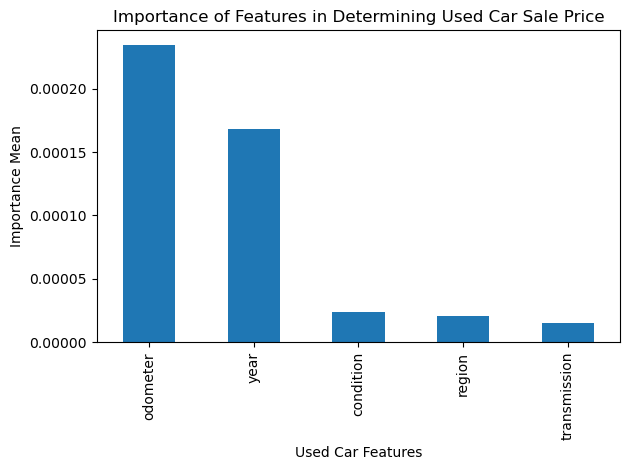

In [463]:
compute_importance(grid_lin.best_estimator_, X_test, y_test, 30)

## Sequential Feature Selection with Linear Regressor

In [464]:
selector_pipe = Pipeline([('transformer', col_transformer),
                    ('selector', SequentialFeatureSelector(LinearRegression())),
                    ('model', LinearRegression())])

param_dict = {"selector__n_features_to_select":[2,3,4,5]}
selector_grid = GridSearchCV(estimator=selector_pipe, param_grid=param_dict)

Feature Importances
-------------------
year     0.000 +/- 0.000
type     0.000 +/- 0.000
odometer 0.000 +/- 0.000
transmission 0.000 +/- 0.000
condition 0.000 +/- 0.000
model    0.000 +/- 0.000
manufacturer 0.000 +/- 0.000
region   0.000 +/- 0.000
 
Estimator Score: 8.930927772110575e-05
Prediction Error (MSE) 41054923571802.18


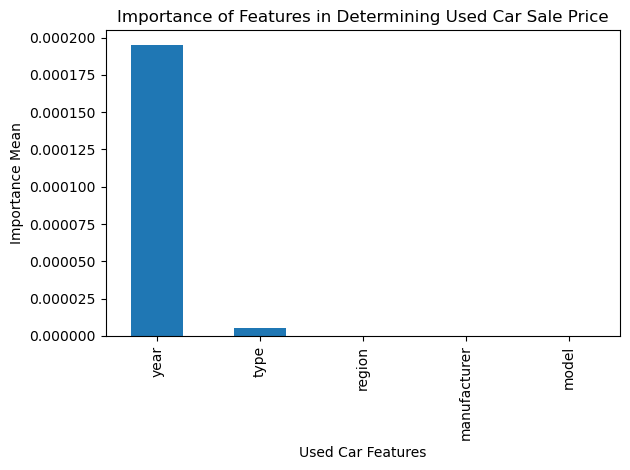

In [465]:
selector_grid.fit(X_train, y_train)

best_estimator = selector_grid.best_estimator_
compute_importance(best_estimator, X_test, y_test, 30)

## Ridge Regressor with TransformedTargetRegressor

Feature Importances
-------------------
odometer 0.000 +/- 0.000
year     0.000 +/- 0.000
condition 0.000 +/- 0.000
region   0.000 +/- 0.000
transmission 0.000 +/- 0.000
type     0.000 +/- 0.000
model    0.000 +/- 0.000
manufacturer -0.000 +/- 0.000
 
Estimator Score: 0.00028395354641586046
Prediction Error (MSE) 41046931752483.625


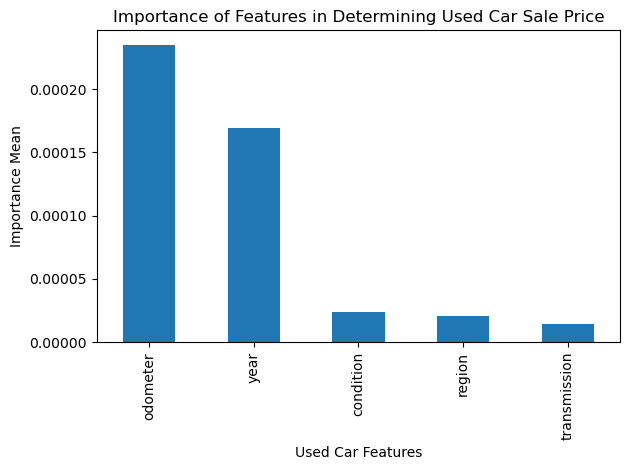

In [466]:
# Let's first begin by finding the best alpha for Ridge using Grid Search

ridge_pipe = Pipeline([('transformer', col_transformer),
                    ("scaler", StandardScaler()),
                    ('Ridge', Ridge())])
params_dict = {"Ridge__alpha":[1e-10, 0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]}

ridge_grid = GridSearchCV(ridge_pipe, param_grid=params_dict)
ridge_grid.fit(X_train, y_train)

best_ridge = ridge_grid.best_estimator_.named_steps['Ridge']

trans_pipe = Pipeline([('transformer', col_transformer), 
                ('regressor', TransformedTargetRegressor(regressor=best_ridge))])
trans_pipe.fit(X_train, y_train)

compute_importance(trans_pipe, X_test, y_test, 30)

## Lasso with RFE

Feature Importances
-------------------
year     0.000 +/- 0.000
condition 0.000 +/- 0.000
region   0.000 +/- 0.000
transmission 0.000 +/- 0.000
type     0.000 +/- 0.000
model    0.000 +/- 0.000
odometer 0.000 +/- 0.000
manufacturer -0.000 +/- 0.000
 
Estimator Score: 5.1958502377935645e-05
Prediction Error (MSE) 41056457141991.29


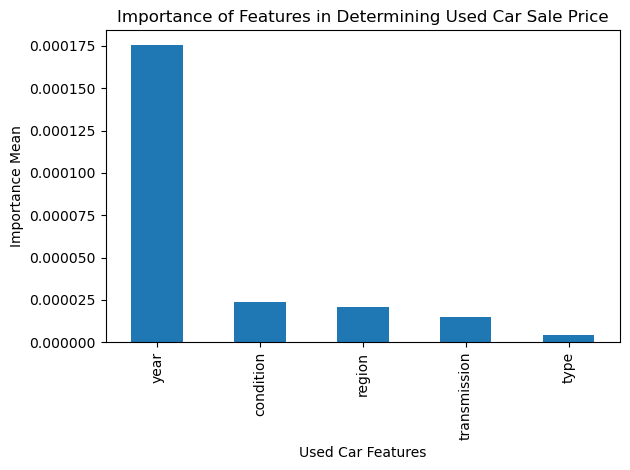

In [467]:
rfe_pipe = Pipeline([('transformer', col_transformer),
                    ('rfe', RFE(estimator=Lasso(), n_features_to_select=8))])
rfe_pipe.fit(X_train, y_train)

compute_importance(rfe_pipe, X_test, y_test, 30)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

## Models

### We tried 4 different models:

1. Linear regression with polynomial features
1. Sequential feature scan using linear regressor
1. Ridge regressor with Transformed Target Regressor
1. RFE with Lasso Regressor

On computing the importance of the used car feature on price, the Linear Regressor with Ploynomial features and the Ridge regressor model came back with the same importance order for the features. Though the mean square error for all these models were quite huge, relatively speaking these two models has the best score and the least MSE.

Note that the feature importance of the Sequential feature selector and the Lasso model did not contradict the results from the other two models. 

## Conclusion 

For the aforementioned reasons we will go with the results obtained from the better models which determing the following features to be most impactful on price.

Features in descending order of impact on used car price:
1. odometer
1. year
1. condition
1. region
1. transmission

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### Dear Used Car Dealers,

We are delighted to share with you the Analysis we did on over 425,000 used car transactions to determine the most important car features that impact the selling price of a used car.

#### Top features that determine the selling price of your used car

Though there are no surprises here, what we know is now backed by historical data. More importantly we are able to provide you a way to include your future sales data and generate reports that would inform you of any changes in factors that impact used car sale price.

Here are the used car features in the order of importance:

1. **Odometer Reading:** The odometer reading is the top factor that determines the sale price of a used car. It will hence be important to source cars with best odometer readings.
1. **Year of manufacture:** Age of the car has the next biggest impact on price. This will be another important factor while adding to the used car inventory.
1. **Condition of the used car:** The condition of the car (new, like new, excellent, good, fair, salvage) determines how high or low sale price the used car would command.
1. **Dealership Region:** If you plan to open dealiship in multiple regions, the choice of the region impacts the price at which you can list the car for sale.
1. **Car Transmission:** Whether the used car has an automatic or manual transmission determines its price after all the above factors.

Here is a visual reprsentation of how important each of the above factors are relative to each other in determiniting the sale price of a used car:

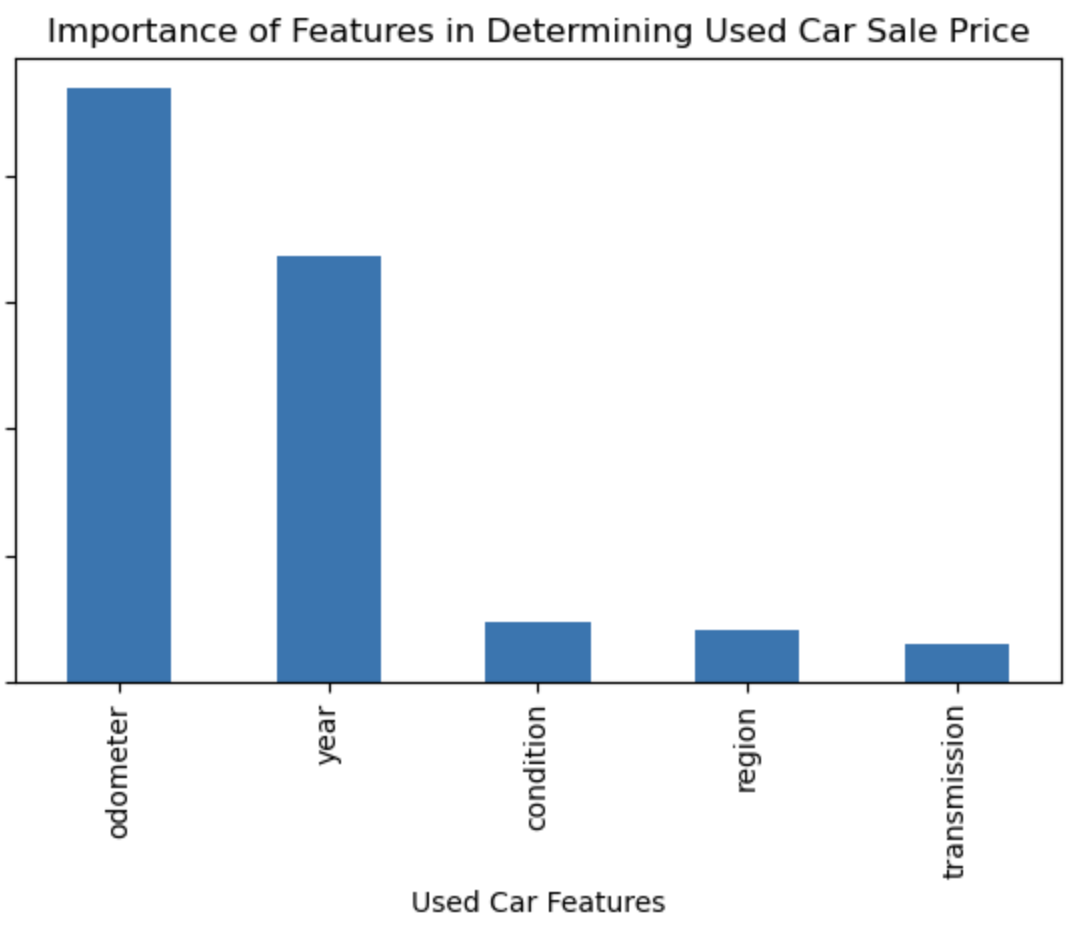

#### A tool for the future

We will be deploying a software on your dealership computers that will let you enter your used car sales data on an ongoing basis. The tool will use historical data and the new data you enter to generate a report on features that impact the used car sale price on any given day.

You will then be able to generate the report once or twice a year to determine if there has been a shift in factors that impact sales price of your used cars.

We hope this tool will help improve the value of your inventory and make you more profitable. Good luck!

**Sincerely,**

**The Berkeley Engineering/HaaS Data Analytics Team**